In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib widget
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.colors as colors
np.set_printoptions(precision=2)
#from lab_utils_multiclass_TF import *
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
import warnings

# Functions

In [2]:
dkcolors = plt.cm.Paired((1,3,7,9,5,11))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
#plt.style.use('./deeplearning.mplstyle')

In [3]:
def plt_mc(X_train,y_train,classes, centers, std):
    css = np.unique(y_train)                    # Find the unique element of an array. Return the sorted unique elements of an array.
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax, X_train,y_train, classes, map=dkcolors_map, legend=True, size=50, equal_xy = False)
    ax.set_title("Multiclass Data")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    #for c in css:
    #    circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
    #    ax.add_patch(circ)
    plt.show()

In [4]:
def plt_mc_data(ax, X, y, clasess, class_label=None, map=plt.cm.Paired, legend=False, size=50, m='o', equal_xy = False):
    """
    Plot multiclass data. Note, if equal_xy is True, setting ylim on the plot may not work
    """

    for i in range(clasess):
        idx = np.where(y == i) # (ndarray): Return elements chosen from x or y depending on condition
        col = len(idx[0])*[i]
        label = class_label[i] if class_label else "c{}".format(i)      # Determines what label use for each class in the plot (c0, c1, c2, c3)
         # this didn't work on coursera but did in local version
        #ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
        #            c=col, vmin=0, vmax=map.N, cmap=map,
        #            s=size, label=label)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    color=map(col), vmin=0, vmax=map.N, 
                    s=size, label=label)
    if legend: ax.legend()
    if equal_xy: ax.axis("equal")


In [5]:
def plt_cat_mc(X_train, y_train, model, classes):
    #make a model for plotting routines to call
    model_predict = lambda Xl: np.argmax(model.predict(Xl),axis=1)

    fig,ax = plt.subplots(1,1, figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
 
    #add the original data to the decison boundary
    plt_mc_data(ax, X_train,y_train, classes, map=dkcolors_map, legend=True)
    #plot the decison boundary. 
    plot_cat_decision_boundary_mc(ax, X_train, model_predict, vector=True)
    ax.set_title("model decision boundary")

    plt.xlabel(r'$x_0$');
    plt.ylabel(r"$x_1$"); 
    plt.show()

In [6]:
def plot_cat_decision_boundary_mc(ax, X, predict , class_labels=None, legend=False, vector=True):

    # create a mesh to points to plot
    x_min, x_max = X[:, 0].min()- 0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()- 0.5, X[:, 1].max()+0.5
    h = max(x_max-x_min, y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #print("xx.shape", xx.shape)

    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, linewidths=1) 
    #ax.axis('tight')

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
def plt_prob_z(ax,fwb, x0_rng=(-8,8), x1_rng=(-5,4)):
    """ plots a decision boundary but include shading to indicate the probability
        and adds a conouter to show where z=0
    """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(x0_rng[0], x0_rng[1], 40)
    x1_space  = np.linspace(x1_rng[0], x1_rng[1], 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    c = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)
            c[i,j] = 0. if z[i,j] == 0 else 1.
    with warnings.catch_warnings():  # suppress no contour warning
        warnings.simplefilter("ignore")
        #ax.contour(tmp_x0, tmp_x1, c, colors='b', linewidths=1) 
        ax.contour(tmp_x0, tmp_x1, c, linewidths=1) 

    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.7)

    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=np.amin(z), vmax=np.amax(z)),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [9]:
def plt_layer_relu(X, Y, W1, b1, classes):
    nunits = (W1.shape[1])
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(7,2.5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    for i in range(nunits):
        layerf= lambda x : np.maximum(0,(np.dot(x,W1[:,i]) + b1[i]))
        plt_prob_z(ax[i], layerf)
        plt_mc_data(ax[i], X, Y, classes, map=dkcolors_map,legend=True, size=50, m='o')
        ax[i].set_title(f"Layer 1 Unit {i}")
        ax[i].set_ylabel(r"$x_1$",size=10)
        ax[i].set_xlabel(r"$x_0$",size=10)
    fig.tight_layout()
    plt.show()

In [25]:
def plt_output_layer_linear(X, Y, W, b, classes, x0_rng=None, x1_rng=None):
    nunits = (W.shape[1])
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(2,int(nunits/2), figsize=(7,5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    for i,axi in enumerate(ax.flat):
        layerf = lambda x : np.dot(x,W[:,i]) + b[i]
        plt_prob_z(axi, layerf, x0_rng=x0_rng, x1_rng=x1_rng)
        plt_mc_data(axi, X, Y, classes, map=dkcolors_map,legend=True, size=50, m='o')
        axi.set_ylabel(r"$a^{[1]}_1$",size=9)
        axi.set_xlabel(r"$a^{[1]}_0$",size=9)
        axi.set_xlim(x0_rng)
        axi.set_ylim(x1_rng)
        axi.set_title(f"Linear Output Unit {i}")
    fig.tight_layout()
    plt.show()

# Prepare and visualize the data

In [10]:
classes = 4
m = 100
centers = [[-5,2], [-2,-2], [1,2], [5,-2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=30)

Exploring the data:

In [11]:
y_train.shape

(100,)

In [12]:
X_train.shape

(100, 2)

In [13]:
print(y_train)      #classes
print(X_train)      #data

[3 3 3 0 3 3 3 3 2 0 2 1 1 1 0 3 2 3 1 2 3 0 1 2 2 0 3 1 0 0 3 0 3 2 3 1 1
 2 3 0 0 2 3 0 3 1 1 3 3 0 0 2 0 2 2 0 0 3 3 2 0 0 0 1 2 1 1 1 3 1 1 2 3 0
 1 2 2 0 1 1 2 2 2 1 1 0 1 0 2 3 3 0 2 1 2 1 1 2 2 0]
[[ 4.33e+00 -1.99e+00]
 [ 4.10e+00 -2.31e+00]
 [ 4.50e+00 -2.19e+00]
 [-5.40e+00  3.02e+00]
 [ 4.22e+00 -3.10e-02]
 [ 3.76e+00 -3.61e+00]
 [ 7.19e+00 -2.76e+00]
 [ 5.44e+00 -1.41e+00]
 [ 1.60e+00  1.63e+00]
 [-5.03e+00  3.39e+00]
 [ 1.23e+00  6.32e-01]
 [-1.22e+00 -3.79e+00]
 [-3.06e+00 -3.28e+00]
 [-1.68e+00 -2.99e+00]
 [-3.57e+00  1.34e+00]
 [ 4.60e+00 -9.70e-01]
 [ 3.83e-02  2.95e+00]
 [ 4.16e+00 -3.48e+00]
 [-7.32e-01 -2.28e+00]
 [ 5.90e-01  2.58e+00]
 [ 4.08e+00 -1.63e+00]
 [-5.29e+00  2.54e+00]
 [-3.16e+00 -2.02e+00]
 [ 1.93e+00  6.09e-01]
 [ 1.47e+00  2.38e+00]
 [-3.62e+00  2.76e+00]
 [ 5.06e+00 -6.77e-03]
 [-2.26e+00 -1.43e+00]
 [-5.39e+00  7.27e-02]
 [-7.08e+00  2.94e+00]
 [ 4.36e+00 -1.60e+00]
 [-3.10e+00  1.65e+00]
 [ 3.61e+00 -1.92e+00]
 [ 2.52e+00  3.24e+00]
 [ 4.94e+00 -1

Let's visualize the classes

/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


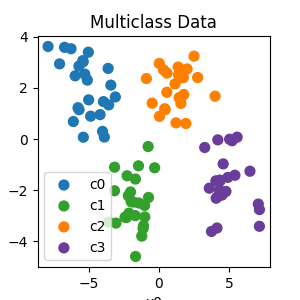

In [14]:
plt_mc(X_train, y_train, classes, centers, std=std)

In [15]:
#show the classes in data set:
print(f"unique classes: {np.unique(y_train)}")
#show how classes are represented
print(f"class representatio {y_train[:10]}")
#show shapes of our dataset
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes: [0 1 2 3]
class representatio [3 3 3 0 3 3 3 3 2 0]
shape of X_train: (100, 2), shape of y_train: (100,)


# Model

Build the network

In [16]:
tf.random.set_seed(1234)    # applied to achieve consistent results
model = Sequential(
    [
        Dense(2, activation='relu', name='L1'),
        Dense(4, activation='linear', name='L2'),
    ]
)

Compile and train the network

In [17]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(0.01),
)

2025-03-27 18:52:08.744293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-27 18:52:08.744520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2537  
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9896 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.7660
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 1.5755
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 1.4167
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.2890
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1888 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 1.1103
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0474
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9964 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9537 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9164 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8830 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.8524
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.8243
Epoch 16/2

Let's see how this model has classified the training data

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


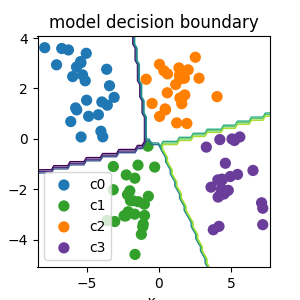

In [19]:
plt_cat_mc(X_train, y_train, model, classes)

In [20]:
# gather the trained parameters from the first layer
l1 = model.get_layer("L1")
W1,b1 = l1.get_weights()

/tmp/ipykernel_72810/4237677390.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)
/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/tmp/ipykernel_72810/4237677390.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)
/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


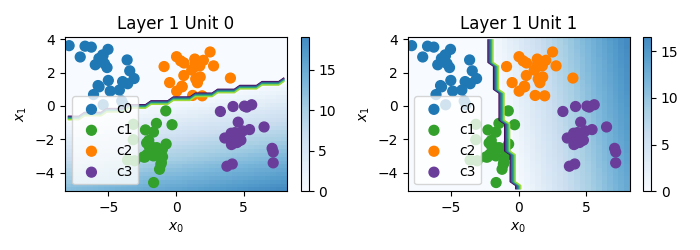

In [23]:
# plot the function of the first layer
plt_layer_relu(X_train, y_train.reshape(-1,), W1, b1, classes)

/tmp/ipykernel_72810/4237677390.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)
/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/tmp/ipykernel_72810/4237677390.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)
/tmp/ipykernel_72810/2484780658.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/tmp/ipykernel_72810/4237677390.py:16: DeprecationWarning: Conversion of an ar

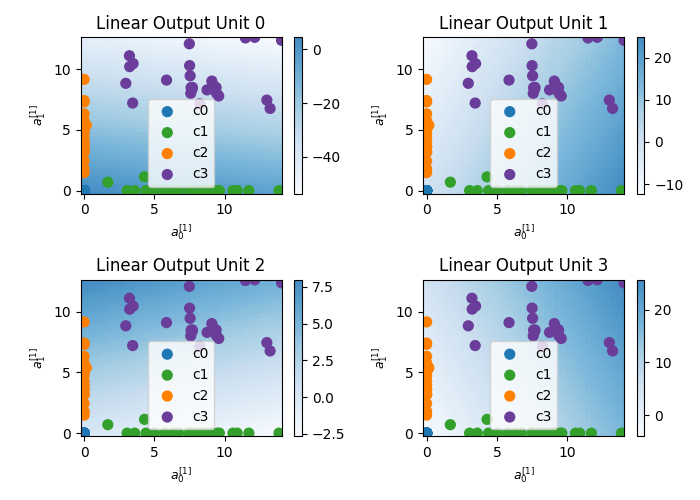

In [26]:
# gather the trained parameters from the output layer
l2 = model.get_layer("L2")
W2, b2 = l2.get_weights()
# create the 'new features', the training examples after L1 transformation
Xl2 = np.maximum(0, np.dot(X_train,W1) + b1)

plt_output_layer_linear(Xl2, y_train.reshape(-1,), W2, b2, classes,
                        x0_rng = (-0.25,np.amax(Xl2[:,0])), x1_rng = (-0.25,np.amax(Xl2[:,1])))

# Explanation
## Layer 1

These plots show the function of Units 0 and 1 in the first layer of the network. The inputs are (𝑥0,𝑥1
) on the axis. The output of the unit is represented by the color of the background. This is indicated by the color bar on the right of each graph. Notice that since these units are using a ReLu, the outputs do not necessarily fall between 0 and 1 and in this case are greater than 20 at their peaks. The contour lines in this graph show the transition point between the output, 𝑎[1]𝑗

being zero and non-zero. Recall the graph for a ReLu : The contour line in the graph is the inflection point in the ReLu.

Unit 0 has separated classes 0 and 1 from classes 2 and 3. Points to the left of the line (classes 0 and 1) will output zero, while points to the right will output a value greater than zero.
Unit 1 has separated classes 0 and 2 from classes 1 and 3. Points above the line (classes 0 and 2 ) will output a zero, while points below will output a value greater than zero. Let's see how this works out in the next layer!

## Layer 2, the output layer

The dots in these graphs are the training examples translated by the first layer. One way to think of this is the first layer has created a new set of features for evaluation by the 2nd layer. The axes in these plots are the outputs of the previous layer 𝑎[1]0
and 𝑎[1]1. As predicted above, classes 0 and 1 (blue and green) have 𝑎[1]0=0 while classes 0 and 2 (blue and orange) have 𝑎[1]1=0

.
Once again, the intensity of the background color indicates the highest values.
- Unit 0 will produce its maximum value for values near (0,0), where class 0 (blue) has been mapped.
- Unit 1 produces its highest values in the upper left corner selecting class 1 (green).
- Unit 2 targets the lower right corner where class 2 (orange) resides.
- Unit 3 produces its highest values in the upper right selecting our final class (purple).

One other aspect that is not obvious from the graphs is that the values have been coordinated between the units. It is not sufficient for a unit to produce a maximum value for the class it is selecting for, it must also be the highest value of all the units for points in that class. This is done by the implied softmax function that is part of the loss function `SparseCategoricalCrossEntropy`. Unlike other activation functions, the softmax works across all the outputs.